In [1]:
import sys
sys.path.append(
    "/home/user/Documents/OTUS/HW_03/"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

from src.signal_processing import *

%load_ext autoreload
%autoreload 2

In [2]:
INPUT_DATA_PATH = "./data/Epileptic Seizure Recognition.csv"

input_data = pd.read_csv(INPUT_DATA_PATH)

# 1. EDA

In [3]:
print(f"Shape: {input_data.shape}")
print(f"Dtypes: {input_data.dtypes.value_counts()}")
print(f"Missing_values: {input_data.isna().sum().sum()}")

Shape: (11500, 180)
Dtypes: int64     179
object      1
dtype: int64
Missing_values: 0


In [4]:
FEATURE_COLUMNS = input_data.columns.tolist()
TARGET_COLUMN = "y"
FEATURE_COLUMNS.remove(TARGET_COLUMN)
FEATURE_COLUMNS.remove("Unnamed")

In [5]:
input_data[TARGET_COLUMN] = np.where(input_data[TARGET_COLUMN] > 1, 0, 1)

In [6]:
input_data[TARGET_COLUMN].value_counts()

0    9200
1    2300
Name: y, dtype: int64

Data is imbalanced so it is better to use stratification for splits

In [7]:
X = input_data[FEATURE_COLUMNS]
y = input_data[TARGET_COLUMN]

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1337)
train_idx, test_idx = next(strat_shuff_split.split(X, y))

X_train = input_data.loc[train_idx, X.columns.values]
y_train = input_data.loc[train_idx, 'y']

X_test = input_data.loc[test_idx, X.columns.values]
y_test = input_data.loc[test_idx, 'y']

In [8]:
# Stratification check
print(y_train.value_counts(normalize=True).sort_index())
print(y_test.value_counts(normalize=True).sort_index())

0    0.8
1    0.2
Name: y, dtype: float64
0    0.8
1    0.2
Name: y, dtype: float64


# 2. ML

<AxesSubplot:>

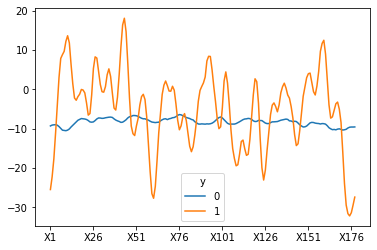

In [9]:
pd.DataFrame(X_train).groupby(pd.Series(y_train)).mean().T.plot()

### 2.1 Baseline

In [10]:
from catboost import CatBoostClassifier

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [11]:
classifiers = [
    LogisticRegression(verbose=False),
    SVC(verbose=False),
    RandomForestClassifier(verbose=False),
    CatBoostClassifier(verbose=False)
]

In [12]:
def create_report(clf_list, X_train, y_train, X_test, y_test):
    for clf in clf_list:
        clf_name = clf.__class__.__name__
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        train_f1_score = f1_score(y_train, clf.predict(X_train))
        test_f1_score = f1_score(y_test, y_pred)

        print("=" * 50)
        print(clf_name)
        print(f"Train score: {train_f1_score}")
        print(f"Test score: {test_f1_score}")
        print(classification_report(y_test, y_pred))

In [13]:
create_report(classifiers, X_train, y_train, X_test, y_test)

LogisticRegression
Train score: 0.3692870201096892
Test score: 0.3155299917830731
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1840
           1       0.25      0.42      0.32       460

    accuracy                           0.64      2300
   macro avg       0.54      0.56      0.53      2300
weighted avg       0.71      0.64      0.67      2300

SVC
Train score: 0.9547738693467338
Test score: 0.9348066298342542
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.95      0.92      0.93       460

    accuracy                           0.97      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300

RandomForestClassifier
Train score: 1.0
Test score: 0.9535135135135134
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1     

### 2.2 FFT

In [14]:
N = 178     # длина сигнала
f_s = 178  # частота Hz
t_n = 1  # длина нашего сигнала в секундах
T = t_n / N # период сигнала
sample_rate = 1 / f_s
denominator = 10

In [15]:
X_train_fft, _ = extract_features_labels(X_train, y_train.values, T, N, f_s, denominator)
X_test_fft, _ = extract_features_labels(X_test, y_test.values, T, N, f_s, denominator)

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

<AxesSubplot:>

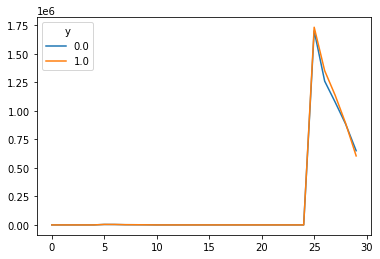

In [16]:
pd.DataFrame(X_train_fft).groupby(pd.Series(y_train)).mean().T.plot()

In [17]:
print(f"New features count: {X_train_fft.shape[1]}")
print(f"Features dimension reduction: {X_train.shape[1] - X_train_fft.shape[1]}")

New features count: 30
Features dimension reduction: 148


In [18]:
clf = CatBoostClassifier(verbose=False)

In [19]:
create_report([clf], X_train_fft, y_train, X_test_fft, y_test)

CatBoostClassifier
Train score: 0.9991845610220169
Test score: 0.9620801733477788
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.96      0.97      0.96       460

    accuracy                           0.98      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.98      0.98      0.98      2300



In [20]:
top_features = np.argwhere(clf.feature_importances_ > 2).flatten()

In [21]:
clf.feature_importances_[top_features].shape

(20,)

In [22]:
clf_top_features_only = CatBoostClassifier(verbose=False)

In [23]:
create_report([clf_top_features_only], X_train_fft[:, top_features], y_train, X_test_fft[:, top_features], y_test)

CatBoostClassifier
Train score: 0.9991845610220169
Test score: 0.9621621621621621
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.96      0.97      0.96       460

    accuracy                           0.98      2300
   macro avg       0.97      0.98      0.98      2300
weighted avg       0.98      0.98      0.98      2300



### 2.3 Wavelet

In [24]:
# According to this paper (pdf inside)
# https://www.mdpi.com/1424-8220/15/11/29015/pdf

waveletname = 'sym9'
X_train_wt, _ = get_uci_har_features(X_train, y_train, waveletname)
X_test_wt, _ = get_uci_har_features(X_test, y_test, waveletname)

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

<AxesSubplot:>

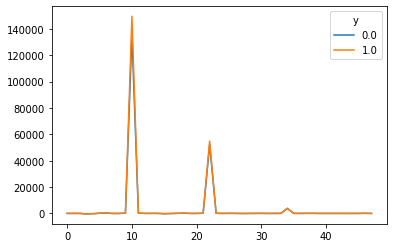

In [25]:
pd.DataFrame(X_train_wt).groupby(pd.Series(y_train)).mean().T.plot()

In [26]:
print(f"New features count: {X_train_wt.shape[1]}")
print(f"Features dimension reduction: {X_train.shape[1] - X_train_wt.shape[1]}")

New features count: 48
Features dimension reduction: 130


In [27]:
clf = CatBoostClassifier(verbose=False)

In [28]:
create_report([clf], X_train_wt, y_train, X_test_wt, y_test)

CatBoostClassifier
Train score: 1.0
Test score: 0.9696969696969697
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.97      0.97      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300



In [29]:
top_features = np.argwhere(clf.feature_importances_ > 1.95).flatten()

In [30]:
clf.feature_importances_[top_features].shape

(18,)

In [31]:
clf_top_features_only = CatBoostClassifier(verbose=False)

In [32]:
create_report([clf_top_features_only], X_train_wt[:, top_features], y_train, X_test_wt[:, top_features], y_test)

CatBoostClassifier
Train score: 0.999728187007339
Test score: 0.9761904761904762
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1840
           1       0.97      0.98      0.98       460

    accuracy                           0.99      2300
   macro avg       0.98      0.99      0.99      2300
weighted avg       0.99      0.99      0.99      2300



### 2.4 Fourier + Wavelet

In [33]:
clf_top_features_only = CatBoostClassifier(verbose=False)

In [34]:
create_report([clf], np.concatenate([X_train_fft, X_train_wt], axis=1), y_train, np.concatenate([X_test_fft, X_test_wt], axis=1), y_test)

CatBoostClassifier
Train score: 1.0
Test score: 0.9761388286334056
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.97      0.98      0.98       460

    accuracy                           0.99      2300
   macro avg       0.98      0.99      0.99      2300
weighted avg       0.99      0.99      0.99      2300



In [35]:
top_features = np.argwhere(clf.feature_importances_ > 2).flatten()

In [36]:
clf.feature_importances_[top_features].shape

(14,)

In [37]:
clf_top_features_only = CatBoostClassifier(verbose=False)

In [38]:
create_report([clf_top_features_only], np.concatenate([X_train_fft, X_train_wt], axis=1), y_train, np.concatenate([X_test_fft, X_test_wt], axis=1), y_test)

CatBoostClassifier
Train score: 1.0
Test score: 0.9761388286334056
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.97      0.98      0.98       460

    accuracy                           0.99      2300
   macro avg       0.98      0.99      0.99      2300
weighted avg       0.99      0.99      0.99      2300



### 2.5 Automatic static features

In [39]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [40]:
train_df = input_data.iloc[train_idx].drop(columns=[TARGET_COLUMN])
test_df = input_data.iloc[test_idx].drop(columns=[TARGET_COLUMN])

In [41]:
settings_efficient = settings.TimeBasedFCParameters()
settings_efficient.update(settings.MinimalFCParameters())
settings_efficient.update(settings.IndexBasedFCParameters())

In [42]:
def get_long_dfs(data):
    signal_df_long = pd.DataFrame(
        {
            0: data.reshape(-1),
            1: np.arange(data.shape[0]).repeat(data.shape[1])
        }
    )
    return signal_df_long

def extract_tsfeatures(data, settings):
    long_dfs = get_long_dfs(data)
    signal_features = []
    s_features = extract_features(
        long_dfs, column_id=1, 
        impute_function=impute, 
        default_fc_parameters=settings_efficient,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
    )
    signal_features.append(s_features)
    signal_features_df = pd.concat(signal_features, axis=1)
    return signal_features_df

In [43]:
y_train_feat = y_train.copy()
y_test_feat = y_test.copy()

In [44]:
X_train_eff = extract_tsfeatures(X_train.values, settings_efficient)
X_test_eff = extract_tsfeatures(X_test.values, settings_efficient)

In [47]:
X_train_eff.shape[1]

12

In [45]:
clf_top_features_only = CatBoostClassifier(verbose=False)

In [46]:
create_report([clf], X_train_eff, y_train, X_test_eff, y_test)

CatBoostClassifier
Train score: 0.9888313810950695
Test score: 0.9410503751339765
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1840
           1       0.93      0.95      0.94       460

    accuracy                           0.98      2300
   macro avg       0.96      0.97      0.96      2300
weighted avg       0.98      0.98      0.98      2300



## Выводы

* Наилучший скор показала модель, построенная с использованием wavelet transform и использующая топ-18 признаков из всего набора.
* Сравнимый с лучшим скор показала модель, построенная на топ-14 признаках, где были применены обе трансформации Fourier и Wavelet
* Модель, построенная с использованием только Fourier признаков, дала лучший результат, чем baseline модель.
* Модель, построенная с использованием библиотеки для автоматической генерации признаков, показала сравнимый с baseline моделью скор, но тем не менее он оказался ненсколько ниже. Возможно, эта модель нуждается в дополнительной более тонкой настройке. Ее плюсом является то, что она использует наименьшее количество признаков - 12.
* Изначальгно в baseline моделе использовалось 178 признаков. Таким образом с использованием трансформаций удалось уменьшить размерность признаков в ~10 раз и при этом улучшить скор моделей